In [9]:
%pip install kagglehub
%pip install pymysql sqlalchemy

Note: you may need to restart the kernel to use updated packages.
   ---------------------------------------- 0.0/2.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.1 MB ? eta -:--:--
   ---- ----------------------------------- 0.3/2.1 MB ? eta -:--:--
   ---- ----------------------------------- 0.3/2.1 MB ? eta -:--:--
   ---- ----------------------------------- 0.3/2.1 MB ? eta -:--:--
   --------- ------------------------------ 0.5/2.1 MB 409.0 kB/s eta 0:00:04
   --------- ------------------------------ 0.5/2.1 MB 409.0 kB/s eta 0:00:04
   -------------- ------------------------- 0.8/2.1 MB 459.5 kB/s eta 0:00:03
   -------------- ------------------------- 0.8/2.1 MB 459.5 kB/s eta 0:00:03
   ------------------- -------------------- 1.0/2.1 MB 529.6 kB/s eta 0:00:03
   ------------------------ --------------- 1.3/2.1 MB 610.0 kB/s eta 0:00:02
   ----------------------------- ---------- 1.6/2.1 MB 693.1 kB/s eta 0:00:01
   ---------------------------------- -----

# **Alasan Pemilihan Topik**


kami memilih topik Analisis E-Commerence terhadap Inflasi Mata Uang Brazil yang memiliki tujuan untuk mengetahui pengaruh inflasi terhadap daya beli penduduk Brazil dengan rentang waktu dari 2016 - 2018. Dataset utama yang digunakan yaitu "olistbr/brazilian-ecommerce" yang kami ambil dari kaggle dan dataset kedua "lucashmateo/brazil-inflation-data" yang juga kami ambil dari kaggle.


In [17]:
import os
import shutil
import time
import glob
import kagglehub
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sqlalchemy import create_engine, text
from datetime import datetime
import pymysql

# **Extract**

In [18]:
LOCAL_BASE_DIR = "C:\\Users\\LENOVO LOQ\\OneDrive - Telkom University\\Documents\\Kuliah\\Tugas dan Materi\\Semester 7\\Big Data\\UAS_BigData"

if not os.path.exists(LOCAL_BASE_DIR):
    os.makedirs(LOCAL_BASE_DIR)

def extract_from_kaggle(source_name, folder_suffix):
    """
    Fungsi untuk download dari Kaggle dan memindahkannya ke folder lokal
    """
    print(f"--- Memulai Ekstraksi: {source_name} ---")
    start_time = time.time()

    try:
        path = kagglehub.dataset_download(source_name)
        print(f"Download selesai di cache: {path}")
    except Exception as e:
        print(f"Gagal download: {e}")
        return

    destination_folder = os.path.join(LOCAL_BASE_DIR, folder_suffix) 
    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)

    files = glob.glob(os.path.join(path, "*.*")) 
    for file in files:
        file_name = os.path.basename(file)
        dest_path = os.path.join(destination_folder, file_name)
        
        if not os.path.exists(dest_path):
            shutil.copy(file, dest_path)
            print(f"Berhasil memindahkan: {file_name}")
        else:
            print(f"File sudah ada: {file_name}")

    print(f"\nVerifikasi Data di: {destination_folder}")
    local_files = glob.glob(os.path.join(destination_folder, "*.csv"))
    
    total_size = 0
    for f in local_files:
        size = os.path.getsize(f) / (1024 * 1024) # MB
        total_size += size
        df_temp = pd.read_csv(f, nrows=5) # Cek header saja
        print(f"- {os.path.basename(f)}: {df_temp.shape[1]} Kolom, Size: {size:.2f} MB")

    print(f"Total Ukuran: {total_size:.2f} MB")
    print(f"Waktu Eksekusi: {time.time() - start_time:.2f} detik\n")
    return destination_folder

path_ecommerce = extract_from_kaggle("olistbr/brazilian-ecommerce", "brazilian-ecommerce")
path_inflation = extract_from_kaggle("lucashmateo/brazil-inflation-data", "brazil-inflation-data")

--- Memulai Ekstraksi: olistbr/brazilian-ecommerce ---
Download selesai di cache: C:\Users\LENOVO LOQ\.cache\kagglehub\datasets\olistbr\brazilian-ecommerce\versions\2
File sudah ada: olist_customers_dataset.csv
File sudah ada: olist_geolocation_dataset.csv
File sudah ada: olist_orders_dataset.csv
File sudah ada: olist_order_items_dataset.csv
File sudah ada: olist_order_payments_dataset.csv
File sudah ada: olist_order_reviews_dataset.csv
File sudah ada: olist_products_dataset.csv
File sudah ada: olist_sellers_dataset.csv
File sudah ada: product_category_name_translation.csv

Verifikasi Data di: C:\Users\LENOVO LOQ\OneDrive - Telkom University\Documents\Kuliah\Tugas dan Materi\Semester 7\Big Data\UAS_BigData\brazilian-ecommerce
- olist_customers_dataset.csv: 5 Kolom, Size: 8.62 MB
- olist_geolocation_dataset.csv: 5 Kolom, Size: 58.44 MB
- olist_orders_dataset.csv: 8 Kolom, Size: 16.84 MB
- olist_order_items_dataset.csv: 7 Kolom, Size: 14.72 MB
- olist_order_payments_dataset.csv: 5 Kolom,

# **Transform**

[INFO] Source 1: Memuat dataset dari C:\Users\LENOVO LOQ\OneDrive - Telkom University\Documents\Kuliah\Tugas dan Materi\Semester 7\Big Data\UAS_BigData\brazilian-ecommerce...

SOURCE 1: LAPORAN SEBELUM TRANSFORMASI
Total Baris: 112650
Total Kolom: 26

[1] Missing Values per Kolom:
order_approved_at                  15
order_delivered_carrier_date     1194
order_delivered_customer_date    2454
product_category_name            1603
product_name_lenght              1603
product_description_lenght       1603
product_photos_qty               1603
product_weight_g                   18
product_length_cm                  18
product_height_cm                  18
product_width_cm                   18
dtype: int64

[2] Cek Duplikasi:
Baris duplikat penuh: 0
Duplikat Primary Key (order_id, order_item_id): 0

[3] Menampilkan Visualisasi Boxplot...


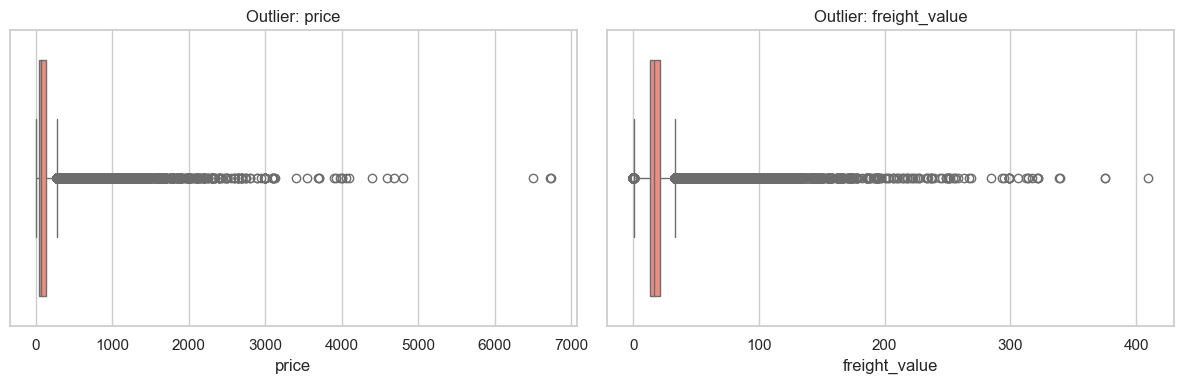


[4] Statistik Deskriptif Outlier (IQR):
- Kolom 'price': Terdeteksi 8427 outliers (7.48%)
- Kolom 'freight_value': Terdeteksi 12134 outliers (10.77%)

MEMULAI PROSES TRANSFORMASI (CLEANING & ENGINEERING)

Transformasi Selesai.

SOURCE 1: LAPORAN SESUDAH TRANSFORMASI
Total Baris: 112650
Total Kolom: 28

[1] Missing Values per Kolom:
Tidak ada missing value.

[2] Cek Duplikasi:
Baris duplikat penuh: 0
Duplikat Primary Key (order_id, order_item_id): 0

[3] Menampilkan Visualisasi Boxplot...


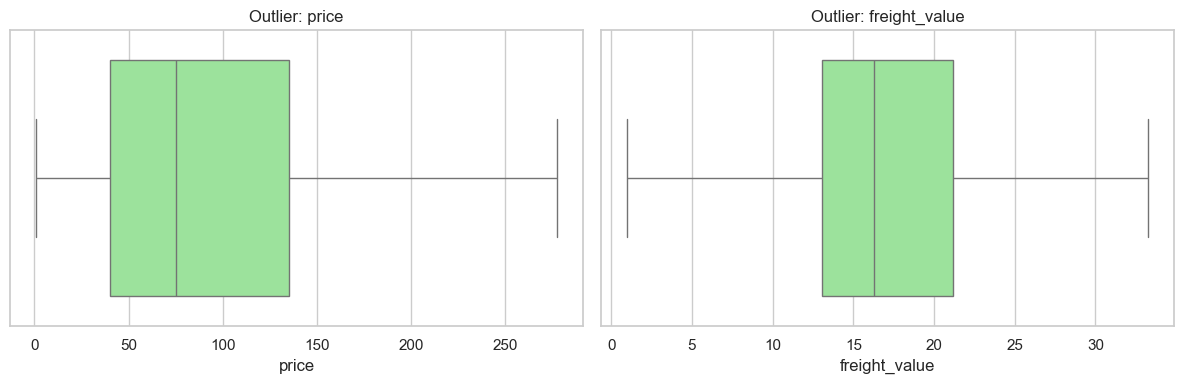


[4] Statistik Deskriptif Outlier (IQR):
- Kolom 'price': Terdeteksi 0 outliers (0.0%)
- Kolom 'freight_value': Terdeteksi 0 outliers (0.0%)

[SUCCESS] File hasil transformasi tersimpan di: C:\Users\LENOVO LOQ\OneDrive - Telkom University\Documents\Kuliah\Tugas dan Materi\Semester 7\Big Data\UAS_BigData\PipelineETL\transformed_source1_brazilian_ecommerce.csv


In [ ]:
sns.set_theme(style="whitegrid")

class OlistTransformer:
    def __init__(self, raw_path):
        self.raw_path = raw_path
        self.df = None
        self.df_raw = None
        self.quality_report = {}

    def load_and_merge_internal(self):
        """[C.1] Menggabungkan tabel internal Olist"""
        print(f"[INFO] Source 1: Memuat dataset dari {self.raw_path}...")
        
        orders = pd.read_csv(os.path.join(self.raw_path, 'olist_orders_dataset.csv'))
        items = pd.read_csv(os.path.join(self.raw_path, 'olist_order_items_dataset.csv'))
        cust = pd.read_csv(os.path.join(self.raw_path, 'olist_customers_dataset.csv'))
        prod = pd.read_csv(os.path.join(self.raw_path, 'olist_products_dataset.csv'))

        df = items.merge(orders, on='order_id', how='left')
        df = df.merge(cust, on='customer_id', how='left')
        self.df_raw = df.merge(prod, on='product_id', how='left')
        self.df = self.df_raw.copy()
        return self.df

    def _generate_detailed_report(self, df, title, color):
        print("\n" + "="*60)
        print(f"{title}")
        print("="*60)
        print(f"Total Baris: {df.shape[0]}")
        print(f"Total Kolom: {df.shape[1]}")

        # 1. Missing Values per Kolom
        print("\n[1] Missing Values per Kolom:")
        missing = df.isnull().sum()
        if missing.sum() > 0:
            print(missing[missing > 0])
        else:
            print("Tidak ada missing value.")

        # 2. Cek Duplikasi
        print("\n[2] Cek Duplikasi:")
        print(f"Baris duplikat penuh: {df.duplicated().sum()}")
        pk_cols = ['order_id', 'order_item_id']
        if all(col in df.columns for col in pk_cols):
             print(f"Duplikat Primary Key (order_id, order_item_id): {df.duplicated(subset=pk_cols).sum()}")

        # 3. Visualisasi Outlier
        num_cols = ['price', 'freight_value']
        print("\n[3] Menampilkan Visualisasi Boxplot...")
        plt.figure(figsize=(12, 4))
        for i, col in enumerate(num_cols):
            if col in df.columns:
                plt.subplot(1, 2, i+1)
                sns.boxplot(data=df, x=col, color=color)
                plt.title(f"Outlier: {col}")
        plt.tight_layout()
        plt.show()

        # 4. Statistik Deskriptif Outlier (IQR)
        print("\n[4] Statistik Deskriptif Outlier (IQR):")
        for col in num_cols:
            if col in df.columns:
                Q1 = df[col].quantile(0.25)
                Q3 = df[col].quantile(0.75)
                IQR = Q3 - Q1
                lower_bound = Q1 - 1.5 * IQR
                upper_bound = Q3 + 1.5 * IQR
                outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
                print(f"- Kolom '{col}': Terdeteksi {len(outliers)} outliers ({round(len(outliers)/len(df)*100, 2)}%)")

    def pre_transformation_report(self):
        self._generate_detailed_report(self.df_raw, "SOURCE 1: LAPORAN SEBELUM TRANSFORMASI", "salmon")

    def transform_pipeline(self):
        print("\n" + "="*60)
        print("MEMULAI PROSES TRANSFORMASI (CLEANING & ENGINEERING)")
        print("="*60)

        # --- a. Data Cleaning ---
        self.df.drop_duplicates(subset=['order_id', 'order_item_id'], inplace=True)

        date_cols = ['order_purchase_timestamp', 'order_delivered_customer_date', 'order_estimated_delivery_date']
        for col in date_cols:
            self.df[col] = pd.to_datetime(self.df[col], errors='coerce')

        # Imputasi Logis
        self.df['order_delivered_customer_date'] = self.df['order_delivered_customer_date'].fillna(self.df['order_estimated_delivery_date'])

        # Imputasi Sisa (Median untuk numerik, Unknown untuk kategorikal)
        num_cols_list = self.df.select_dtypes(include=[np.number]).columns
        self.df[num_cols_list] = self.df[num_cols_list].fillna(self.df[num_cols_list].median())

        obj_cols_list = self.df.select_dtypes(include=['object']).columns
        self.df[obj_cols_list] = self.df[obj_cols_list].fillna("Unknown")

        # --- b. Penanganan Outlier (IQR Capping) ---
        for col in ['price', 'freight_value']:
            Q1 = self.df[col].quantile(0.25)
            Q3 = self.df[col].quantile(0.75)
            IQR = Q3 - Q1
            self.df[col] = np.clip(self.df[col], Q1 - 1.5*IQR, Q3 + 1.5*IQR)

        # --- c. Standardization & Engineering ---
        self.df.columns = [c.lower().strip().replace(' ', '_') for c in self.df.columns]
        self.df['price_norm'] = MinMaxScaler().fit_transform(self.df[['price']])
        self.df['delivery_days'] = (self.df['order_delivered_customer_date'] - self.df['order_purchase_timestamp']).dt.days.clip(lower=0)

        print("\nTransformasi Selesai.")
        return self.df

    def post_transformation_report(self):
        self._generate_detailed_report(self.df, "SOURCE 1: LAPORAN SESUDAH TRANSFORMASI", "lightgreen")


path_s1 = "C:\\Users\\LENOVO LOQ\\OneDrive - Telkom University\\Documents\\Kuliah\\Tugas dan Materi\\Semester 7\\Big Data\\UAS_BigData\\brazilian-ecommerce" # ubah file disini (Folder Input)
output_file = "C:\\Users\\LENOVO LOQ\\OneDrive - Telkom University\\Documents\\Kuliah\\Tugas dan Materi\\Semester 7\\Big Data\\UAS_BigData\\PipelineETL\\transformed_source1_brazilian_ecommerce.csv" # ubah file disini (File Output)
if os.path.exists(path_s1):
    trans1 = OlistTransformer(path_s1)
    trans1.load_and_merge_internal()
    trans1.pre_transformation_report()
    df_s1_final = trans1.transform_pipeline()
    trans1.post_transformation_report()
    df_s1_final.to_csv(output_file, index=False)
    print(f"\n[SUCCESS] File hasil transformasi tersimpan di: {output_file}")
else:
    print(f"[ERROR] Folder input tidak ditemukan di: {path_s1}")

[INFO] Source 2: Memuat data inflasi Brasil...

SOURCE 2: LAPORAN SEBELUM TRANSFORMASI
Total Baris: 40
Total Kolom: 13

[1] Missing Values per Kolom:
February     1
March        1
April        1
May          1
June         1
July         1
August       1
September    1
October      1
November     1
December     1
dtype: int64

[2] Cek Duplikasi:
Baris duplikat penuh: 0
Duplikat Primary Key (Year): 0

[3] Menampilkan Visualisasi Boxplot (Seluruh Bulan)...


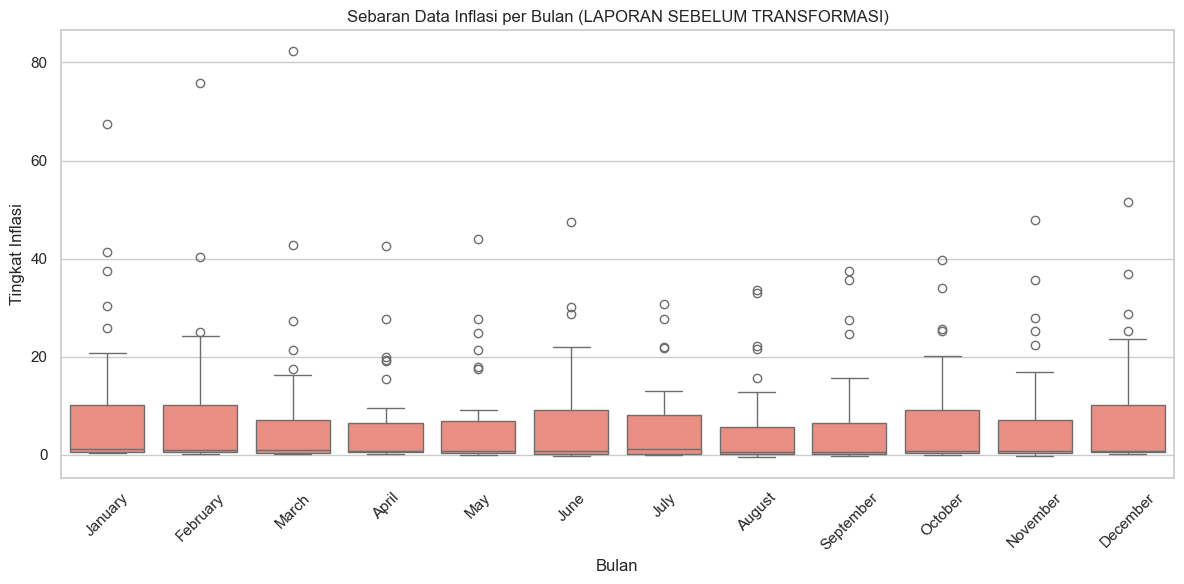


[4] Statistik Deskriptif Outlier (IQR) - Sampel Januari & Juli:
- Kolom 'January': Terdeteksi 5 outliers (12.5%)
- Kolom 'July': Terdeteksi 4 outliers (10.0%)

MEMULAI PROSES TRANSFORMASI SOURCE 2 (WIDE FORMAT CLEANING)

Transformasi Selesai.

SOURCE 2: LAPORAN SESUDAH TRANSFORMASI
Total Baris: 40
Total Kolom: 22

[1] Missing Values per Kolom:
Tidak ada missing value.

[2] Cek Duplikasi:
Baris duplikat penuh: 0
Duplikat Primary Key (year): 0

[3] Menampilkan Visualisasi Boxplot (Seluruh Bulan)...


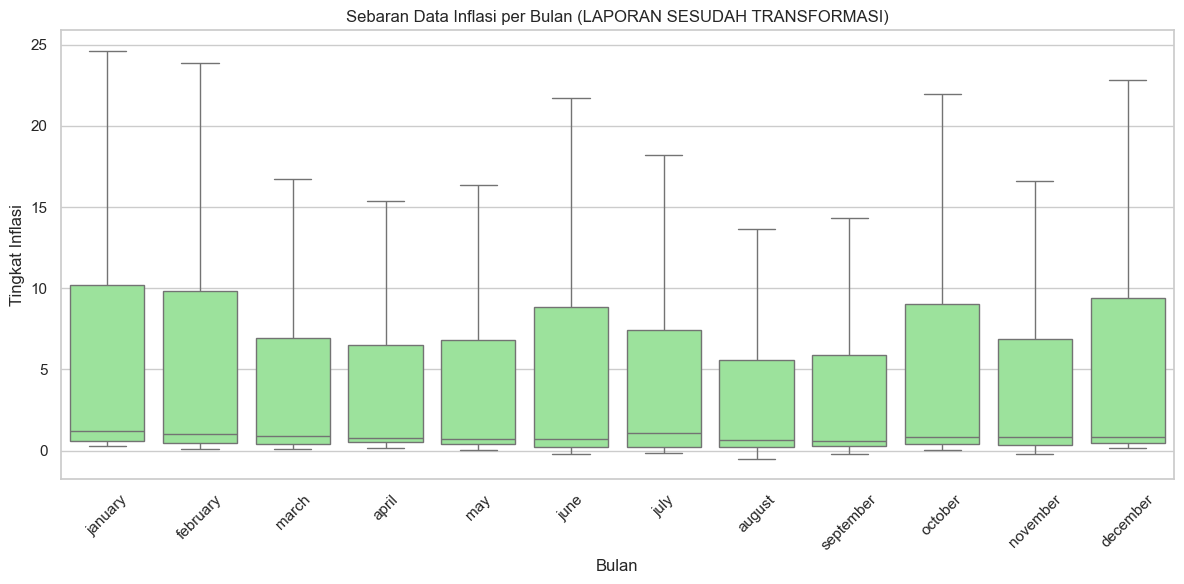


[4] Statistik Deskriptif Outlier (IQR) - Sampel Januari & Juli:
- Kolom 'january': Terdeteksi 0 outliers (0.0%)
- Kolom 'july': Terdeteksi 0 outliers (0.0%)


In [14]:
sns.set_theme(style="whitegrid")

class InflationTransformer:
    def __init__(self, raw_path):
        self.raw_path = raw_path
        self.df = None
        self.df_raw = None
        self.months = ['January', 'February', 'March', 'April', 'May', 'June',
                       'July', 'August', 'September', 'October', 'November', 'December']
        self.quality_report = {}

    def load_data(self):
        """[C.1] Memuat data dan membersihkan header"""
        print("[INFO] Source 2: Memuat data inflasi Brasil...")
        file_path = os.path.join(self.raw_path, 'brazil.inflation.monthly (statbureau.org).csv')

        self.df_raw = pd.read_csv(file_path)
        self.df_raw.columns = self.df_raw.columns.str.strip()

        if 'Total' in self.df_raw.columns:
            self.df_raw = self.df_raw.drop(columns=['Total'])

        self.df = self.df_raw.copy()
        return self.df

    def _generate_detailed_report(self, df, title, color):
        """Fungsi helper untuk membuat laporan mendalam sesuai kaidah tugas"""
        print("\n" + "="*60)
        print(f"{title}")
        print("="*60)
        print(f"Total Baris: {df.shape[0]}")
        print(f"Total Kolom: {df.shape[1]}")

        # 1. Missing Values per Kolom
        print("\n[1] Missing Values per Kolom:")
        missing = df.isnull().sum()
        print(missing[missing > 0] if missing.sum() > 0 else "Tidak ada missing value.")

        # 2. Cek Duplikasi
        print("\n[2] Cek Duplikasi:")
        print(f"Baris duplikat penuh: {df.duplicated().sum()}")

        year_pk_col = 'Year' if 'Year' in df.columns else 'year'
        if year_pk_col in df.columns:
            print(f"Duplikat Primary Key ({year_pk_col}): {df.duplicated(subset=[year_pk_col]).sum()}")
        else:
            print(f"Column '{year_pk_col}' not found for duplicate check.")

        # 3. Visualisasi Outlier (Menampilkan sebaran inflasi tahunan)
        print("\n[3] Menampilkan Visualisasi Boxplot (Seluruh Bulan)...")
        plt.figure(figsize=(12, 6))

        current_month_cols = [m for m in self.months if m in df.columns]
        if not current_month_cols:
            current_month_cols = [m.lower() for m in self.months if m.lower() in df.columns]

        if year_pk_col in df.columns and current_month_cols:
            df_plot = df.melt(id_vars=[year_pk_col], value_vars=current_month_cols, var_name='Bulan', value_name='Tingkat Inflasi')
            sns.boxplot(data=df_plot, x='Bulan', y='Tingkat Inflasi', color=color)
            plt.title(f"Sebaran Data Inflasi per Bulan ({title.split(':')[1].strip()})")
            plt.xticks(rotation=45)
            plt.xlabel("Bulan")
            plt.ylabel("Tingkat Inflasi")
            plt.tight_layout()
            plt.show()
        else:
            print(f"Could not find year column ('Year' or 'year') or month columns ({current_month_cols}) for plotting.")

        # 4. Statistik Deskriptif Outlier (IQR) - Mengambil sampel beberapa bulan
        print("\n[4] Statistik Deskriptif Outlier (IQR) - Sampel Januari & Juli:")
        sample_cols_report = ['January', 'July']
        if 'january' in df.columns and 'july' in df.columns:
            sample_cols_report = ['january', 'july']

        for col in sample_cols_report:
            if col in df.columns:
                Q1 = df[col].quantile(0.25)
                Q3 = df[col].quantile(0.75)
                IQR = Q3 - Q1
                lower = Q1 - 1.5 * IQR
                upper = Q3 + 1.5 * IQR
                outliers = df[(df[col] < lower) | (df[col] > upper)]
                print(f"- Kolom '{col}': Terdeteksi {len(outliers)} outliers ({round(len(outliers)/len(df)*100, 2)}%)")

    def pre_transformation_report(self):
        self._generate_detailed_report(self.df_raw, "SOURCE 2: LAPORAN SEBELUM TRANSFORMASI", "salmon")

    def transform_pipeline(self):
        print("\n" + "="*60)
        print("MEMULAI PROSES TRANSFORMASI SOURCE 2 (WIDE FORMAT CLEANING)")
        print("="*60)

        df = self.df.copy()

        # --- a. Data Cleaning ---
        df.drop_duplicates(subset=['Year'] if 'Year' in df.columns else ['year'], inplace=True)

        for month in self.months:
            if month in df.columns:
                df[month] = df[month].fillna(df[month].median())

        for month in self.months:
            if month in df.columns:
                Q1 = df[month].quantile(0.25)
                Q3 = df[month].quantile(0.75)
                IQR = Q3 - Q1
                df[month] = np.clip(df[month], Q1 - 1.5*IQR, Q3 + 1.5*IQR)

        # --- b. Standardisasi Data ---
        df.columns = [c.lower().strip() for c in df.columns]

        scaler = MinMaxScaler()
        df[['january_norm', 'december_norm']] = scaler.fit_transform(df[['january', 'december']])

        avg_annual = df[ [m.lower() for m in self.months] ].mean(axis=1)
        df['inflation_risk'] = pd.cut(avg_annual, bins=[-np.inf, 0.5, 2.0, np.inf], labels=['Low', 'Medium', 'High'])
        df['risk_encoded'] = LabelEncoder().fit_transform(df['inflation_risk'])

        # --- c. Feature Engineering ---
        df['yearly_avg'] = df[ [m.lower() for m in self.months] ].mean(axis=1)
        df['yearly_max'] = df[ [m.lower() for m in self.months] ].max(axis=1)
        df['yearly_std'] = df[ [m.lower() for m in self.months] ].std(axis=1)
        df['is_volatile'] = (df['yearly_std'] > 0.5).astype(int)
        df['year_trend_diff'] = df['december'] - df['january']

        # --- d. Validasi Kualitas Data ---
        self.quality_report = {
            "uniqueness_check": df['year'].is_unique,
            "null_check": df.isnull().sum().sum() == 0,
            "range_check": (df['year'] >= 1980).all(),
            "datatype_consistency": pd.api.types.is_numeric_dtype(df['january']),
            "referential_integrity": df['year'].notnull().all(),
            "data_distribution": round(df['yearly_avg'].skew(), 2)
        }

        self.df = df

        print("\nTransformasi Selesai.")
        return self.df

    def post_transformation_report(self):
        original_months = self.months.copy()
        self.months = [m.lower() for m in self.months]
        self._generate_detailed_report(self.df, "SOURCE 2: LAPORAN SESUDAH TRANSFORMASI", "lightgreen")
        self.months = original_months

path_s2 = "C:\\Users\\LENOVO LOQ\\OneDrive - Telkom University\\Documents\\Kuliah\\Tugas dan Materi\\Semester 7\\Big Data\\UAS_BigData\\brazil-inflation-data"
trans2 = InflationTransformer(path_s2)
trans2.load_data()
trans2.pre_transformation_report()
df_s2_final = trans2.transform_pipeline()
trans2.post_transformation_report()

df_s2_final.to_csv('C:\\Users\\LENOVO LOQ\\OneDrive - Telkom University\\Documents\\Kuliah\\Tugas dan Materi\\Semester 7\\Big Data\\UAS_BigData\\PipelineETL\\transformed_source2_inflation_wide.csv', index=False)

# **Load**

In [15]:
DB_USER = 'root'          
DB_PASS = ''              
DB_HOST = 'localhost'     
DB_PORT = '3306'          
DB_NAME = 'olist_dw'      

def log_process(message):
    print(f"[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] {message}")


def main():
    log_process("Memulai Proses ETL Load di Local...")

    # --- 1. MEMBACA DATA DARI FILE CSV ---
    try:
        if not os.path.exists('transformed_source1_brazilian_ecommerce.csv'):
            raise FileNotFoundError("File 'transformed_source1_brazilian_ecommerce.csv' tidak ditemukan!")
            
        df_ecommerce = pd.read_csv('transformed_source1_brazilian_ecommerce.csv')
        df_inflation_wide = pd.read_csv('transformed_source2_inflation_wide.csv')
        log_process("Berhasil membaca file CSV.")
    except Exception as e:
        log_process(f"Error Membaca File: {e}")
        return

    # --- 2. TRANSFORMASI DATA INFLASI (Wide to Long) ---
    try:
        month_map = {
            'january': 1, 'february': 2, 'march': 3, 'april': 4, 'may': 5, 'june': 6,
            'july': 7, 'august': 8, 'september': 9, 'october': 10, 'november': 11, 'december': 12
        }
        cols_to_melt = [c for c in df_inflation_wide.columns if c in month_map.keys()]
        
        df_inflation_long = df_inflation_wide.melt(
            id_vars=['year'], 
            value_vars=cols_to_melt, 
            var_name='month_name', 
            value_name='inflation_rate'
        )
        
        df_inflation_long['month_num'] = df_inflation_long['month_name'].map(month_map)
        
        # Buat Primary Key: year_month (YYYY-MM)
        df_inflation_long['year_month'] = pd.to_datetime(
            df_inflation_long['year'].astype(str) + '-' + df_inflation_long['month_num'].astype(str) + '-01'
        ).dt.strftime('%Y-%m')
        
        # Filter data valid
        dim_inflation = df_inflation_long[['year_month', 'inflation_rate']].dropna().drop_duplicates('year_month')
        log_process("Transformasi Inflasi selesai.")
    except Exception as e:
        log_process(f"Error Transformasi Inflasi: {e}")
        return

    # --- 3. PERSIAPAN DATAFRAME UNTUK TABEL ---
    try:

        dim_customer = df_ecommerce[['customer_id', 'customer_unique_id', 'customer_city', 'customer_state']].drop_duplicates('customer_id')
        if 'product_category_name' in df_ecommerce.columns:
            dim_product = df_ecommerce[['product_id', 'product_category_name']].drop_duplicates('product_id')
        else:
            dim_product = df_ecommerce[['product_id']].drop_duplicates()
            dim_product['product_category_name'] = 'Unknown'

        fact_sales = df_ecommerce.copy()
        fact_sales['order_purchase_timestamp'] = pd.to_datetime(fact_sales['order_purchase_timestamp'])
        fact_sales['year_month'] = fact_sales['order_purchase_timestamp'].dt.strftime('%Y-%m')
        
        fact_cols = ['order_id', 'order_item_id', 'customer_id', 'product_id', 
                     'order_purchase_timestamp', 'price', 'freight_value', 'order_status', 'year_month']

        fact_sales = fact_sales[[c for c in fact_cols if c in fact_sales.columns]]
    except Exception as e:
        log_process(f"Error Persiapan Dataframe: {e}")
        return

    # --- 4. KONEKSI KE DATABASE & LOAD DATA ---
    connection_str = f"mysql+pymysql://{DB_USER}:{DB_PASS}@{DB_HOST}:{DB_PORT}"
    
    try:
        engine_root = create_engine(connection_str)
        with engine_root.connect() as conn:
            conn.execute(text(f"CREATE DATABASE IF NOT EXISTS {DB_NAME}"))
            conn.execute(text(f"USE {DB_NAME}"))
            conn.execute(text("SET FOREIGN_KEY_CHECKS=0;"))
            
            conn.execute(text("DROP TABLE IF EXISTS Fact_Sales"))
            conn.execute(text("DROP TABLE IF EXISTS Dim_Product"))
            conn.execute(text("DROP TABLE IF EXISTS Dim_Customer"))
            conn.execute(text("DROP TABLE IF EXISTS Dim_Inflation"))

            log_process("Membuat Tabel...")
            
            conn.execute(text("""
                CREATE TABLE Dim_Customer (
                    `customer_id` VARCHAR(50) PRIMARY KEY,
                    `customer_unique_id` VARCHAR(50),
                    `customer_city` VARCHAR(100),
                    `customer_state` VARCHAR(5)
                )
            """))
            
            conn.execute(text("""
                CREATE TABLE Dim_Product (
                    `product_id` VARCHAR(50) PRIMARY KEY,
                    `product_category_name` VARCHAR(100)
                )
            """))
            
            conn.execute(text("""
                CREATE TABLE Dim_Inflation (
                    `year_month` VARCHAR(10) PRIMARY KEY,
                    `inflation_rate` FLOAT
                )
            """))
            
            conn.execute(text("""
                CREATE TABLE Fact_Sales (
                    `order_id` VARCHAR(50),
                    `order_item_id` INT,
                    `customer_id` VARCHAR(50),
                    `product_id` VARCHAR(50),
                    `order_purchase_timestamp` DATETIME,
                    `price` FLOAT,
                    `freight_value` FLOAT,
                    `order_status` VARCHAR(50),
                    `year_month` VARCHAR(10),
                    PRIMARY KEY (`order_id`, `order_item_id`),
                    FOREIGN KEY (`customer_id`) REFERENCES Dim_Customer(`customer_id`),
                    FOREIGN KEY (`product_id`) REFERENCES Dim_Product(`product_id`),
                    FOREIGN KEY (`year_month`) REFERENCES Dim_Inflation(`year_month`)
                )
            """))
            conn.execute(text("SET FOREIGN_KEY_CHECKS=1;"))
            log_process("Skema Database Berhasil Dibuat.")

        engine_db = create_engine(f"{connection_str}/{DB_NAME}")
        
        log_process("Sedang memuat data ke MySQL (Mungkin butuh waktu beberapa saat)...")
        
        dim_customer.to_sql('Dim_Customer', engine_db, if_exists='append', index=False, chunksize=10000)
        dim_product.to_sql('Dim_Product', engine_db, if_exists='append', index=False, chunksize=10000)
        dim_inflation.to_sql('Dim_Inflation', engine_db, if_exists='append', index=False, chunksize=10000)
        fact_sales.to_sql('Fact_Sales', engine_db, if_exists='append', index=False, chunksize=10000)

        log_process("SUKSES! Semua data berhasil dimuat ke Data Warehouse.")
        
    except Exception as e:
        log_process(f"TERJADI ERROR PADA DATABASE: {e}")
        print("\nSaran: Periksa username, password, dan apakah MySQL Server sudah berjalan.")

if __name__ == "__main__":
    main()

[2025-12-24 12:59:16] Memulai Proses ETL Load di Local...
[2025-12-24 12:59:17] Berhasil membaca file CSV.
[2025-12-24 12:59:17] Transformasi Inflasi selesai.
[2025-12-24 12:59:18] Membuat Tabel...
[2025-12-24 12:59:18] Skema Database Berhasil Dibuat.
[2025-12-24 12:59:18] Sedang memuat data ke MySQL (Mungkin butuh waktu beberapa saat)...


C:\Users\LENOVO LOQ\AppData\Local\Temp\ipykernel_74284\2092350637.py:141: UserWarning: The provided table name 'Dim_Customer' is not found exactly as such in the database after writing the table, possibly due to case sensitivity issues. Consider using lower case table names.
  dim_customer.to_sql('Dim_Customer', engine_db, if_exists='append', index=False, chunksize=10000)
C:\Users\LENOVO LOQ\AppData\Local\Temp\ipykernel_74284\2092350637.py:142: UserWarning: The provided table name 'Dim_Product' is not found exactly as such in the database after writing the table, possibly due to case sensitivity issues. Consider using lower case table names.
  dim_product.to_sql('Dim_Product', engine_db, if_exists='append', index=False, chunksize=10000)
C:\Users\LENOVO LOQ\AppData\Local\Temp\ipykernel_74284\2092350637.py:143: UserWarning: The provided table name 'Dim_Inflation' is not found exactly as such in the database after writing the table, possibly due to case sensitivity issues. Consider using 

[2025-12-24 13:00:03] SUKSES! Semua data berhasil dimuat ke Data Warehouse.


C:\Users\LENOVO LOQ\AppData\Local\Temp\ipykernel_74284\2092350637.py:144: UserWarning: The provided table name 'Fact_Sales' is not found exactly as such in the database after writing the table, possibly due to case sensitivity issues. Consider using lower case table names.
  fact_sales.to_sql('Fact_Sales', engine_db, if_exists='append', index=False, chunksize=10000)
